In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from astropy import units as u
from astropy import io

## 3HSPJ095507+355101

In [2]:
ra, dec = "09 55 07.8818398488", "+35 51 00.885435048"
target = SkyCoord(ra, dec, unit=(u.hourangle, u.deg))

In [3]:
target.ra.deg, target.dec.deg

(148.78284099937, 35.850245954180004)

## IceCube-2001072A

In [4]:
# Date: 20/01/07
# Time: 09:42:18.36  UT

icecube_loc = EarthLocation(lon=0, lat=-90, height=2450)
neutrino_time = Time('2020-01-07T09:42:18.36', scale='utc', location=icecube_loc)
# heliocentric correction
ltt_helio = neutrino_time.light_travel_time(target, 'heliocentric')
neutrino_time_helio = Time(neutrino_time.utc - ltt_helio, format='jd', scale='utc', location=icecube_loc)
neutrino_hjd = neutrino_time_helio.jd

In [5]:
dt = 3.1 * 365
neutrino_time.jd - dt, neutrino_time.jd + dt

(2457724.4043791667, 2459987.4043791667)

## ASAS-SN data

In [6]:
fns = {
    "difference phot. + reference": "data/3HSPJ095507+355101_diff_plus_ref_phot.csv",
    "difference photometry": "data/3HSPJ095507+355101_diff_phot.csv",
    "aperture phot.": "data/3HSPJ095507+355101_apperture_phot.csv"
}

datas = {k: pd.read_csv(v) for k, v in fns.items()}

data goes to -3.04 years before nu


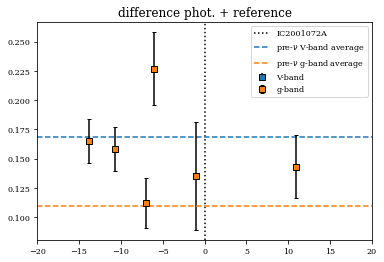

data goes to -3.04 years before nu


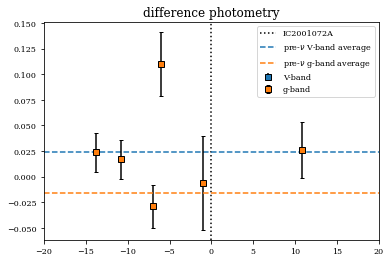

data goes to -3.04 years before nu


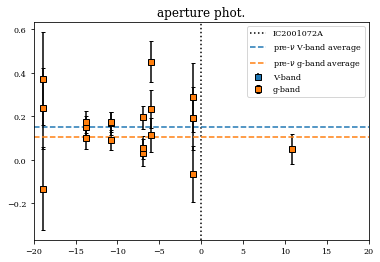

In [7]:
for k, data in datas.items():

    yr_priot = min(data.HJD - neutrino_hjd) / 365
    print(f"data goes to {yr_priot:.2f} years before nu")
    time_from_nu = 20
    t_before_m = data.HJD < (neutrino_hjd - time_from_nu)

    em = data.flux_err < 99.

    tm = abs(data["HJD"] - neutrino_hjd) <= time_from_nu

    fig, ax = plt.subplots()

    ax.axvline(0, label='IC2001072A', c='k', ls=':')

    for i, b in enumerate(data.Filter.unique()):
        bm = data.Filter == b
        d = data[bm & em & tm]
        ax.errorbar(
            x=d['HJD'] - neutrino_hjd,
            y=d['flux(mJy)'],
            yerr=d['flux_err'],
            ls='',
            marker='s', 
            mec='k', 
            ecolor='k', 
            capsize=2, 
            label=f"{b}-band",
            color=f"C{i}"
        )

        avg_d = data[bm & em & t_before_m]
        if len(avg_d):
            avg = np.average(avg_d["flux(mJy)"], weights=1/avg_d["flux_err"])
            ax.axhline(avg, ls='--', label=r"pre-$\nu$ " + b + "-band average", color=f"C{i}")

    ax.set_xlim(-time_from_nu, time_from_nu)
    ylim = ax.get_ylim()
    # ax.set_ylim(-0.08, ylim[1])
    ax.legend()
    ax.set_title(k)
    plt.show()

data goes to -3.04 years before nu
../figures/3HSPJ095507+355101_differencephot+reference.png


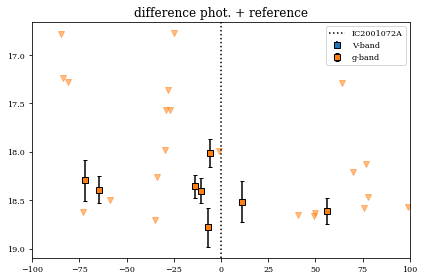

data goes to -3.04 years before nu
../figures/3HSPJ095507+355101_differencephotometry.png


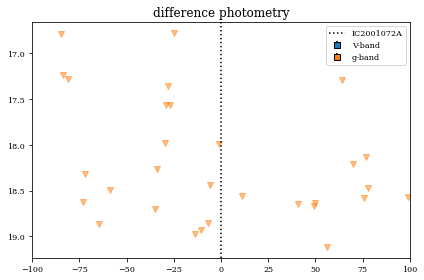

data goes to -3.04 years before nu
../figures/3HSPJ095507+355101_aperturephot.png


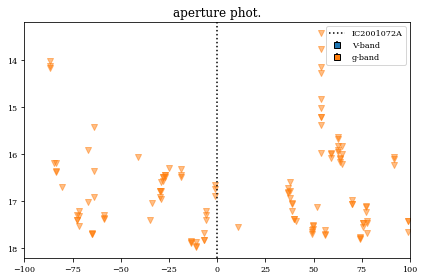

In [45]:
time_from_nu = 100


for k, data in datas.items():
    
    t_before_m = data.HJD < (neutrino_hjd - time_from_nu)
    yr_priot = min(data.HJD - neutrino_hjd) / 365
    print(f"data goes to {yr_priot:.2f} years before nu")

    t_before_m = data.HJD < (neutrino_hjd - time_from_nu)

    em = data.flux_err < 99.

    tm = abs(data["HJD"] - neutrino_hjd) <= time_from_nu
    um = data["mag_err"] == 99.99

    fig, ax = plt.subplots()

    ax.axvline(0, label='IC2001072A', c='k', ls=':')

    for i, b in enumerate(data.Filter.unique()):
        bm = data.Filter == b
        d = data[bm & em & tm]
        d_meas = data[bm & em & tm & ~um]
        d_ulim = data[bm & em & tm & um]

        ax.errorbar(
            x=d_meas['HJD'] - neutrino_hjd,
            y=d_meas['mag'].astype(float),
            yerr=d_meas['mag_err'],
            ls='',
            marker='s', 
            mec='k', 
            ecolor='k', 
            capsize=2, 
            label=f"{b}-band",
            color=f"C{i}"
        )
        ax.scatter(
            d_ulim["HJD"] - neutrino_hjd,
            d_ulim["Limit"],
            marker='v',
            color=f"C{i}",
            alpha=0.5
        )

        # avg_d = data[bm & em & t_before_m]
        # if len(avg_d):
        #     avg = np.average(avg_d["flux(mJy)"], weights=1/avg_d["flux_err"])
        #     ax.axhline(avg, ls='--', label=r"pre-$\nu$ " + b + "-band average", color=f"C{i}")

    ax.set_xlim(-time_from_nu, time_from_nu)
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[1], ylim[0])
    ax.legend()
    ax.set_title(k)
    fig.tight_layout()
    fig_fn = f"../figures/3HSPJ095507+355101_{k.replace(' ', '').replace('.', '')}.png"
    print(fig_fn)
    fig.savefig(fig_fn)
    plt.show()

## ZTF Data

135 detections


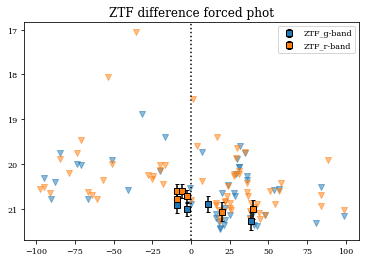

In [46]:
fn = "data/3HSPJ095507+355101_ztffps.txt"

time_from_nu = 100

tab = io.ascii.read(fn)
names = list(tab[0])
names[6] ='info'
names = [i.strip(',') for i in names]
tab = io.ascii.read(fn, names=names)[1:]
tab = tab[tab['programid'] == '1']
tab = tab[~(tab['forcediffimflux'] == 'null')]

f = np.array(tab['forcediffimflux']).astype(float)
fu = np.array(tab['forcediffimfluxunc']).astype(float)
zp = np.array(tab['zpdiff']).astype(float)
t = np.array(tab['jd']).astype(float) #- jdass

mt_p = EarthLocation.of_site("Palomar")
ztf_t = Time(t, scale='utc', location=mt_p, format='jd')
ltt_helio = ztf_t.light_travel_time(target, 'heliocentric')
ztf_helio = Time(ztf_t.utc - ltt_helio, format='jd', scale='utc', location=mt_p)
ztf_hjd = ztf_helio.jd

ztf_tnu = ztf_hjd - neutrino_hjd
tm = abs(ztf_tnu) <= time_from_nu

fltr = tab['filter']

m = f/fu > 5
print(f"{sum(m)} detections")
tab = tab

mag = np.zeros(len(tab))
mage = np.zeros(len(tab))

mag[m] = zp[m] - 2.5*np.log10(f[m])
mage[m] = 1.0857* fu[m] / f[m]

mag[~m] = zp[~m] - 2.5 * np.log10(5 * fu[~m])
mage[~m] = 99.99


fig, ax = plt.subplots()

for i, f in enumerate(np.unique(fltr)):

    fm = fltr == f
    
    ax.errorbar(
        ztf_tnu[m & fm & tm], mag[m & fm & tm], mage[m & fm & tm],
        ls='',
        marker='s', 
        mec='k', 
        ecolor='k', 
        capsize=2, 
        label=f"{f}-band",
        color=f"C{i}"
    )
    ax.scatter(
        ztf_tnu[~m & fm & tm], mag[~m & fm & tm],
        marker='v',
        color=f"C{i}",
        alpha=0.5
    )

ylim = ax.get_ylim()
ax.set_ylim(ylim[1], ylim[0])
ax.legend()
ax.axvline(0, ls=':', color='k')
ax.set_title("ZTF difference forced phot")
plt.show()